# Bayesian Belief Network - Lung cancer

Dane dotyczące raka płuc zostały pobrane z https://www.kaggle.com/mysarahmadbhat/lung-cancer

In [3]:
!pip install pybbn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [4]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
from pybbn.graph.jointree import JoinTree
from pybbn.graph.potential import Potential

In [6]:
pd.options.display.max_columns=50
df=pd.read_csv('lung_cancer.csv', encoding='utf-8')

df['AGE']=df['AGE'].apply(lambda x: 2 if x>60 else 1)
df['GENDER']=df['GENDER'].apply(lambda x: 2 if x == 'M' else 1)
df['LUNG_CANCER']=df['LUNG_CANCER'].apply(lambda x: 2 if x == 'YES' else 1)
df

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,2,2,1,2,2,1,1,2,1,2,2,2,2,2,2,2
1,2,2,2,1,1,1,2,2,2,1,1,1,2,2,2,2
2,1,1,1,1,1,2,1,2,1,2,1,2,2,1,2,1
3,2,2,2,2,2,1,1,1,1,1,2,1,1,2,2,1
4,1,2,1,2,1,1,1,1,1,2,1,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,1,1,1,1,1,2,2,2,1,1,2,2,2,2,1,2
305,2,2,2,1,1,1,1,2,2,2,2,2,2,1,2,2
306,2,1,2,1,1,1,1,1,2,2,2,2,1,1,2,2
307,2,2,2,1,2,1,1,2,2,1,2,2,2,1,2,2


In [7]:
test_count = 50
df_train = df.iloc[:-test_count-1,:]
df_test = df.iloc[-test_count:,:]

In [8]:
# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob  

In [150]:
def create_node(idx, p1=None, p2=None):
    name = df.columns[idx]
    parent1 = df.columns[p1] if p1 != None else None
    parent2 = df.columns[p2] if p2 != None else None
    return BbnNode(Variable(idx, name, [1, 2]), probs(df_train, child=name, parent1=parent1, parent2=parent2)) 

nodes = [
    create_node(0),
    create_node(1),
    create_node(2),
    create_node(3),
    create_node(4),
    create_node(5),
    create_node(6),
    create_node(7),
    create_node(8, 0, 1),
    create_node(9, 2, 3),
    create_node(10, 4, 5),
    create_node(11, 6, 7),
    create_node(12, 8, 9),
    create_node(13, 10, 11),
    create_node(14, 12, 13),
    create_node(15, 14)
]

edges = [
    Edge(nodes[0], nodes[8], EdgeType.DIRECTED),
    Edge(nodes[1], nodes[8], EdgeType.DIRECTED),
    Edge(nodes[2], nodes[9], EdgeType.DIRECTED),
    Edge(nodes[3], nodes[9], EdgeType.DIRECTED),
    Edge(nodes[4], nodes[10], EdgeType.DIRECTED),
    Edge(nodes[5], nodes[10], EdgeType.DIRECTED),
    Edge(nodes[6], nodes[11], EdgeType.DIRECTED),
    Edge(nodes[7], nodes[11], EdgeType.DIRECTED),
    Edge(nodes[8], nodes[12], EdgeType.DIRECTED),
    Edge(nodes[9], nodes[12], EdgeType.DIRECTED),
    Edge(nodes[10], nodes[13], EdgeType.DIRECTED),
    Edge(nodes[11], nodes[13], EdgeType.DIRECTED),
    Edge(nodes[12], nodes[14], EdgeType.DIRECTED),
    Edge(nodes[13], nodes[14], EdgeType.DIRECTED),
    Edge(nodes[14], nodes[15], EdgeType.DIRECTED)
]


def create_network(nodes, edges):
    bbn = Bbn()
    for node in nodes:
        bbn.add_node(node)
    for edge in edges:
        bbn.add_edge(edge)
    return bbn

bbn = create_network(nodes, edges)            

In [151]:
# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

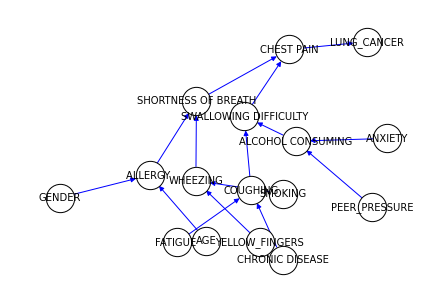

In [152]:
# Set options for graph looks
options = {
    "font_size": 10,
    "node_size": 800,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "blue",
    "linewidths": 1,
    "width": 1,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

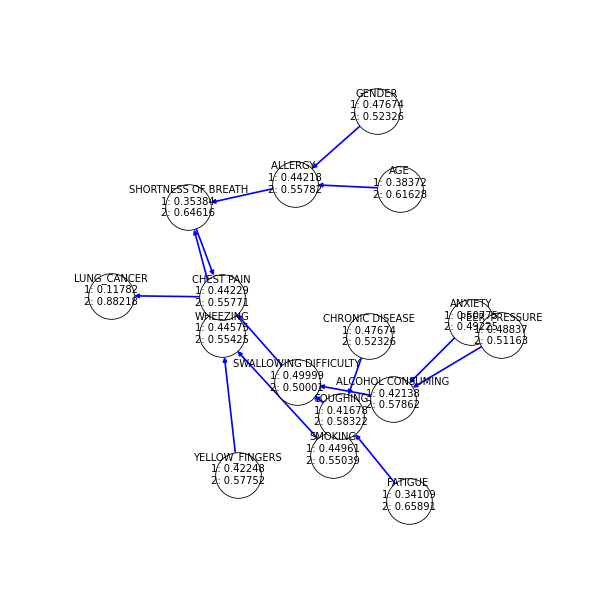

In [153]:
# Define a function for printing marginal probabilities
def print_probs(jt):
    for node in jt.get_bbn_nodes():
        potential = jt.get_bbn_potential(node)
        print("Node:", "dupa")
        print("Values:")
        print(potential)
        print('----------------')

def node_to_text(node, potential):
  node_dict = node.to_dict()
  potential_dict = list(Potential.to_dict([potential]).values())
  text = node_dict['variable']['name'] + "\n"

  for i in range(len(node_dict['variable']['values'])):
    text += f"{node_dict['variable']['values'][i]}: {potential_dict[i]:.5f}\n"
  return text

def draw_graph_probs(jt):
  d_new = { idx : df.columns[idx] for idx in range(len(df.columns)) }
  options2 = {
      "font_size": 12,
      "node_size": 3000,
      "node_color": "white",
      "edgecolors": "black",
      "edge_color": "blue",
      "linewidths": 1,
      "width": 2,
      "node_shape": "o",}
  plt.figure(1, figsize=(10, 10), dpi=60)
  for node in jt.get_bbn_nodes():
    node_dict = node.to_dict()
    potential = jt.get_bbn_potential(node)
    d_new[node_dict['variable']['id']] = node_to_text(node, potential)

  nx.draw(n, labels=d_new, with_labels=True, **options2)
  ax = plt.gca()
  ax.margins(0.20)
  plt.axis("off")
  plt.show()

# Use the above function to print marginal probabilities
# print_probs(join_tree)
draw_graph_probs(join_tree)

In [154]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(jt, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(jt.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    jt.set_observation(ev)

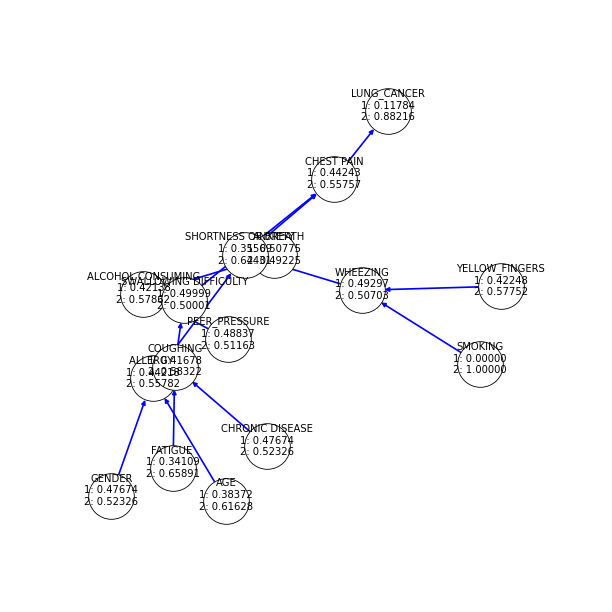

In [155]:
join_tree = InferenceController.apply(bbn)

# Use above function to add evidence
evidence(join_tree, 'SMOKING', 2, 1.0)

# Print marginal probabilities
draw_graph_probs(join_tree)

In [156]:
def test_prediction_for_one_item(bbn, df_item):
  jt = InferenceController.apply(bbn)

  for idx in range(len(df.columns)-1):
    evidence(jt, df.columns[idx], df_item[df.columns[idx]], 1.0)

  pred_dict = list(Potential.to_dict([jt.get_bbn_potential(jt.get_bbn_node_by_name('LUNG_CANCER'))]).values())
  pred = 2 if pred_dict[1] >= 0.8 else 1

  real_value = df_item['LUNG_CANCER']

  return (pred==real_value), pred_dict, pred, real_value

In [157]:
def test_bbn_with_dataframe(bbn, df):
  test_count = df.shape[0]

  test_vals = []
  pred_vals = []

  correct_cnt = 0

  for i in range(test_count):
    df_item = df.iloc[i]
    isCorrect, probabilities, pred, real_value = test_prediction_for_one_item(bbn, df_item)
    correct_cnt += 1 if isCorrect else 0
    test_vals.append(real_value)
    pred_vals.append(pred)
  
  return (correct_cnt/test_count), correct_cnt, test_count, test_vals, pred_vals

In [158]:
accuracy, correct_cnt, test_count, test_vals, pred_vals = test_bbn_with_dataframe(bbn, df_test)
print(f"Accuracy: {accuracy}")
print(f"Correct count: {correct_cnt}, All count: {test_count}")

Accuracy: 0.82
Correct count: 41, All count: 50
